In [21]:
import os
import sys
from pathlib import Path
baseModulePath = str(Path(os.getcwd()).parents[2].absolute())
if baseModulePath not in sys.path:
	sys.path.append(baseModulePath)

import datetime
import pandas as pd
from analisis.general.io_helper import getMkdir

OBSV_DATE = datetime.date(year=2022, month=12, day=6).strftime("%Y-%m-%d")

OBJ_DATA_DIR = "/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464"

DATE_DATA_DIR = [os.path.join(OBJ_DATA_DIR, d) for d in os.listdir(OBJ_DATA_DIR) if OBSV_DATE in d and os.path.isdir(os.path.join(OBJ_DATA_DIR, d))][0]
EPOCH_OBSV_KEY = "E_OTIME"

# TODO on run: update this whenever reference star targets change
STAR_IDS = {
	1: "ATO J339.9469+45.1464", # Object

	# Ref stars
	2: "TYC 3620-332-1",
	3: "TYC 3620-254-1"
}

assert os.path.exists(DATE_DATA_DIR), f"{DATE_DATA_DIR} not found"
DATE_DATA_DIR

'/run/media/ramon/ROG_Data/Tesis/IturbideDatos/ATOJ339.9469+45.1464/2022-12-06'

In [22]:
import numpy as np
from scipy import stats
from astropy.io import ascii

PHOTOMETRIC_BASE_KEYS = ["SUM", "AREA", "FLUX", "MAG", "MERR"]
OBSV_KEY = "OTIME"

qphotResultsDir = os.path.join(DATE_DATA_DIR, "corrected", "iraf-shifted", "qphot-results")
assert os.path.exists(qphotResultsDir), qphotResultsDir

data = ascii.read(os.path.join(qphotResultsDir, "phot"))
pandasData = data.to_pandas()
apertureCols = [c for c in pandasData.columns if c.startswith('RAPERT')]
pandasData[OBSV_KEY] = pd.to_datetime(pandasData[OBSV_KEY])

# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#from-timestamps-to-epoch
# pandasData[EPOCH_OBSV_KEY] = (pandasData[OBSV_KEY] - pd.Timestamp("1970-01-01")) / pd.Timedelta(hours=1.0)
pandasData[EPOCH_OBSV_KEY] = pd.DatetimeIndex(pandasData[OBSV_KEY]).to_julian_date()

for starId, starName in STAR_IDS.items():
	starData = pandasData[pandasData['LID'] == starId].copy()		
	starResultsDir = getMkdir(os.path.join(qphotResultsDir, starName))
	for rapert in apertureCols:
		apertureId = rapert.replace("RAPERT", "")
		apertureRadius = starData.loc[starData.index[0], f"RAPERT{apertureId}"]
		apertureDir = getMkdir(os.path.join(starResultsDir, f"{rapert} - {apertureRadius}"))
		for basePhotKey in PHOTOMETRIC_BASE_KEYS:
			photKey = f"{basePhotKey}{apertureId}"
			photDf = starData[[EPOCH_OBSV_KEY, photKey]].copy()
			photDf = photDf[~(np.isnan(photDf[photKey]))]
			
			photDf['zscore'] = np.abs(stats.zscore(photDf[photKey]))
			photDf = photDf[(np.abs(stats.zscore(photDf[photKey])) < 2)]

			photDf.to_csv(os.path.join(apertureDir, f"{basePhotKey}.dat"), index=False, sep=' ')

data

IMAGE,XINIT,YINIT,ID,COORDS,LID,XCENTER,YCENTER,XSHIFT,YSHIFT,XERR,YERR,CIER,CERROR,MSKY,STDEV,SSKEW,NSKY,NSREJ,SIER,SERROR,ITIME,XAIRMASS,IFILTER,OTIME,RAPERT1,SUM1,AREA1,FLUX1,MAG1,MERR1,PIER1,PERROR1,RAPERT2,SUM2,AREA2,FLUX2,MAG2,MERR2,PIER2,PERROR2,RAPERT3,SUM3,AREA3,FLUX3,MAG3,MERR3,PIER3,PERROR3,RAPERT4,SUM4,AREA4,FLUX4,MAG4,MERR4,PIER4,PERROR4,RAPERT5,SUM5,AREA5,FLUX5,MAG5,MERR5,PIER5,PERROR5,RAPERT6,SUM6,AREA6,FLUX6,MAG6,MERR6,PIER6,PERROR6,RAPERT7,SUM7,AREA7,FLUX7,MAG7,MERR7,PIER7,PERROR7,RAPERT8,SUM8,AREA8,FLUX8,MAG8,MERR8,PIER8,PERROR8,RAPERT9,SUM9,AREA9,FLUX9,MAG9,MERR9,PIER9,PERROR9,RAPERT10,SUM10,AREA10,FLUX10,MAG10,MERR10,PIER10,PERROR10,RAPERT11,SUM11,AREA11,FLUX11,MAG11,MERR11,PIER11,PERROR11
imagename,pixels,pixels,,filename,,pixels,pixels,pixels,pixels,pixels,pixels,,cerrors,counts,counts,counts,npix,npix,,serrors,timeunit,number,name,timeunit,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors,scale,counts,pixels,counts,mag,mag,,perrors
str23,float64,float64,int64,str6,int64,float64,float64,float64,float64,float64,float64,int64,str8,float64,float64,float64,int64,int64,int64,str7,float64,float64,str9,str23,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7,float64,float64,float64,float64,float64,float64,int64,str7
s_bdf_2022-12-06_19-13-,964.000,599.975,1,coords,1,965.627,601.514,1.627,1.539,0.011,0.010,107,BigShift,968.3252,49.93329,5.486055,2301,10,0,NoError,60,1.090537,Luminance,2022-12-06T19:13:29.890,7.00,178257.7,154.4097,28738.91,18.299,0.024,0,NoError,8.00,227178.9,201.142,32408.11,18.169,0.025,0,NoError,9.00,281195.8,254.8449,34423.01,18.103,0.027,0,NoError,10.00,340017,314.3302,35643.19,18.065,0.029,0,NoError,11.00,404747.2,380.2346,36556.4,18.038,0.031,0,NoError,12.00,476227,453.0085,37567.45,18.008,0.034,0,NoError,13.00,551910,530.8476,37876.89,17.999,0.037,0,NoError,14.00,635086.3,616.218,38386.84,17.985,0.040,0,NoError,15.00,722881.1,706.835,38434.97,17.984,0.043,0,NoError,16.00,817426.8,804.6446,38269.21,17.988,0.047,0,NoError,17.00,917326.2,908.4208,37679.51,18.005,0.051,0,NoError
s_bdf_2022-12-06_19-13-,1413.240,755.373,2,coords,2,1414.547,756.695,1.308,1.322,0.002,0.001,107,BigShift,1009.594,63.71385,41.7214,2263,48,0,NoError,60,1.090537,Luminance,2022-12-06T19:13:29.890,7.00,3752872,154.3271,3597064,13.056,0.000,0,NoError,8.00,4194041,201.21,3990901,12.943,0.000,0,NoError,9.00,4549433,254.7531,4292236,12.864,0.000,0,NoError,10.00,4830769,314.4197,4513333,12.809,0.000,0,NoError,11.00,5056681,380.3225,4672709,12.771,0.000,0,NoError,12.00,5243438,452.7045,4786389,12.745,0.000,0,NoError,13.00,5402114,531.0402,4865978,12.727,0.000,0,NoError,14.00,5546066,616.1952,4923959,12.715,0.000,0,NoError,15.00,5678406,706.9996,4964623,12.706,0.000,0,NoError,16.00,5807253,804.4658,4995069,12.699,0.000,0,NoError,17.00,5932990,908.1784,5016098,12.694,0.001,0,NoError
s_bdf_2022-12-06_19-13-,657.405,1072.622,3,coords,3,658.377,1073.520,0.971,0.898,0.002,0.002,0,NoError,987.9053,57.43034,30.62664,2279,31,0,NoError,60,1.090537,Luminance,2022-12-06T19:13:29.890,7.00,2272388,154.4214,2119834,13.630,0.000,

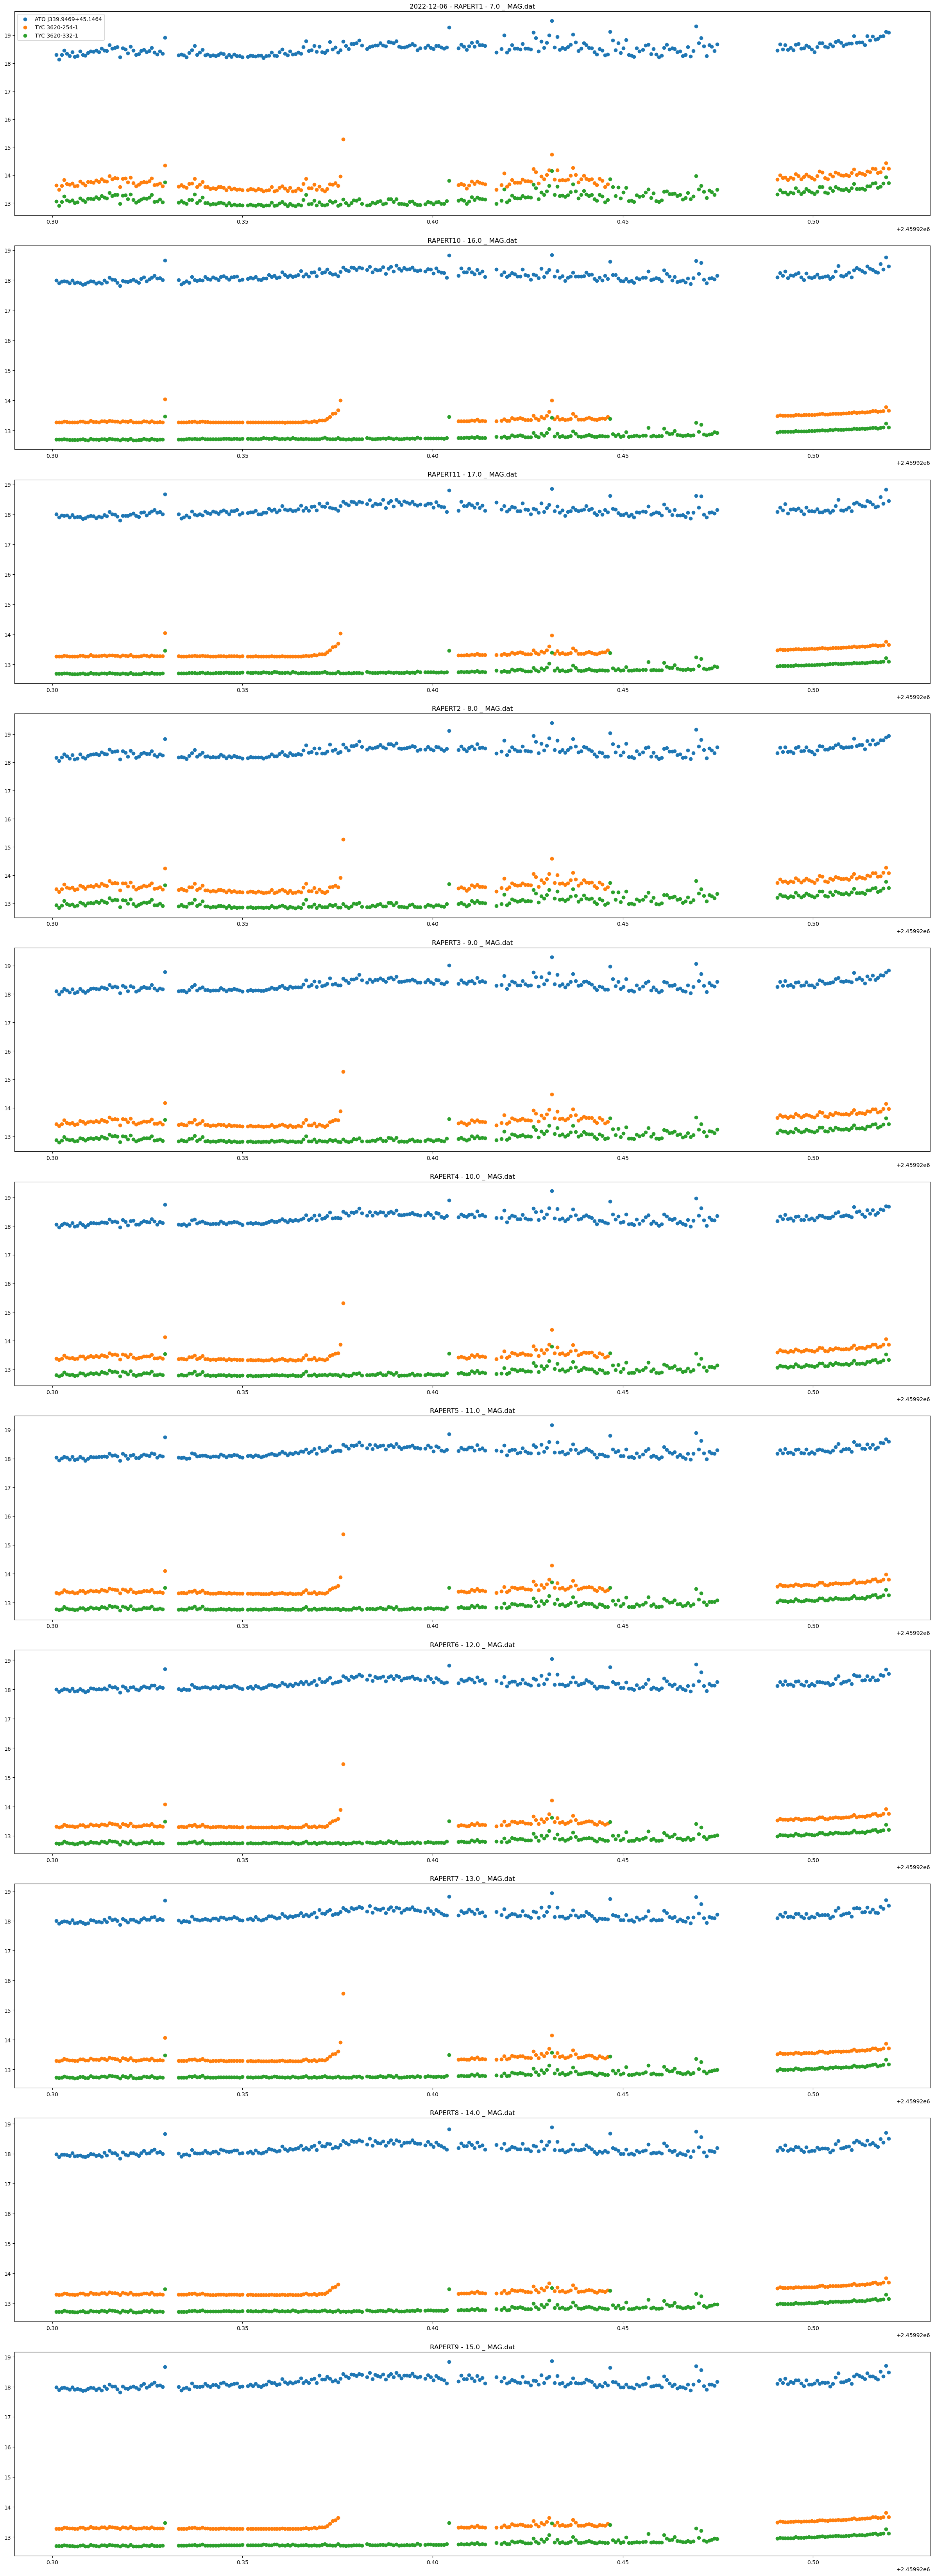

In [23]:
# TODO: try removing data from object where we can see that the reference object has deviated too much
	# can probably try a form of sigma-clipping using TYC 332 mag values, since it looks like at the end they scatter quite a bit

import matplotlib.pyplot as plt

OBJ_NAMES = ["ATO J339.9469+45.1464", "TYC 3620-254-1","TYC 3620-332-1"]
qphotResultsDir = os.path.join(DATE_DATA_DIR, "corrected", "iraf-shifted", "qphot-results")
numApertures = len(os.listdir(os.path.join(qphotResultsDir, OBJ_NAMES[0])))

def plotApertureMeasurements(subplots, quantity: str):
	for i in range(len(subplots)):
		for objName in OBJ_NAMES:
			objDir = os.path.join(qphotResultsDir, objName)
			apertureDirs = os.listdir(objDir)
			curApertureDir = os.path.join(objDir, apertureDirs[i])
			objData = pd.read_csv(os.path.join(curApertureDir, f'{quantity}.dat'), sep=' ')
			dataCol = [c for c in objData.columns if quantity in c][0]
			subplots[i].scatter(objData[EPOCH_OBSV_KEY], objData[dataCol], label=objName)
		if i == 0:
			subplots[i].set_title(f"{OBSV_DATE} - {apertureDirs[i]} _ {quantity}.dat")
		else:
			subplots[i].set_title(f"{apertureDirs[i]} _ {quantity}.dat")

figure, axs = plt.subplots(nrows=numApertures, ncols=1, figsize=(24, 6*numApertures))
plotApertureMeasurements(axs, 'MAG')
figure.tight_layout()
axs[0].legend()
plt.show()